In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv")

print("Dữ liệu gốc:")
print(df.head())
print(df.shape)
print(df['sentiment'].value_counts())

def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))      # xóa HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)     # chỉ giữ chữ cái
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

# Tiền xử lý
df['cleanreview'] = df['review'].apply(clean_text)

# Chỉ giữ 2 cột cần thiết
df = df[['cleanreview', 'sentiment']]

# Lưu tạm
df.to_csv("IMDBclean.csv", index=False)

Dữ liệu gốc:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000, 2)
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [4]:
# Chia File Xử lý
data = pd.read_csv("IMDBclean.csv")

train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])

train.to_csv("IMDBTrain.csv", index=False)
test.to_csv("IMDBTest.csv", index=False)

print(f"Train: {train.shape}, Test: {test.shape}")

Train: (40000, 2), Test: (10000, 2)


In [5]:
# Load dữ liệu chia
train = pd.read_csv("IMDBTrain.csv")
test = pd.read_csv("IMDBTest.csv")

# Chuẩn bị nhãn
y_train = train['sentiment'].map({'positive': 1, 'negative': 0})
y_test = test['sentiment'].map({'positive': 1, 'negative': 0})

X_train = train['cleanreview']
X_test = test['cleanreview']

# TF-IDF Vectorizer (tối ưu cho IMDB)
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    max_features=40000,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**WordCloud**

1-Gram

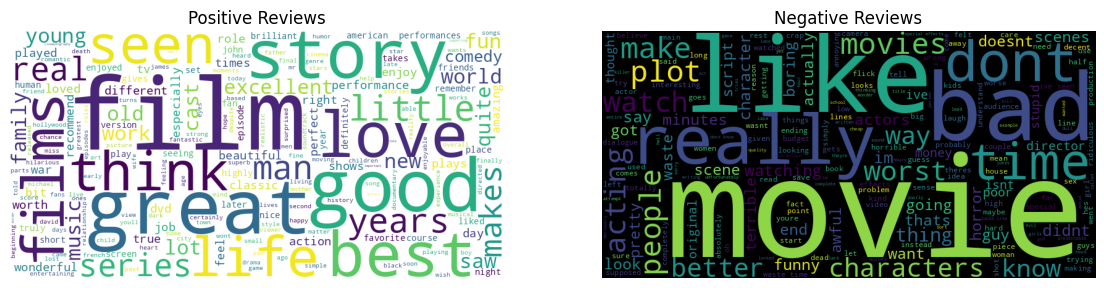

In [6]:
df['label'] = df['sentiment'].map({
    'positive': 1,
    'negative': 0
})


vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

X = vectorizer.fit_transform(df['cleanreview'])
features = vectorizer.get_feature_names_out()

pos_idx = df[df['label'] == 1].index
neg_idx = df[df['label'] == 0].index

pos_score = X[pos_idx].mean(axis=0).A1
neg_score = X[neg_idx].mean(axis=0).A1

pos_words = {}
neg_words = {}

for i, w in enumerate(features):
    if pos_score[i] > neg_score[i]:
        pos_words[w] = pos_score[i]
    elif neg_score[i] > pos_score[i]:
        neg_words[w] = neg_score[i]

wc_pos = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(pos_words)

wc_neg = WordCloud(
    width=800,
    height=400,
    background_color='black'
).generate_from_frequencies(neg_words)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.imshow(wc_pos)
plt.title("Positive Reviews")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_neg)
plt.title("Negative Reviews")
plt.axis("off")

plt.show()


In [7]:
# Top 10 words most representative for each class
print("Top Positive words:")
for w, s in sorted(pos_words.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(w)

print("\nTop Negative words:")
for w, s in sorted(neg_words.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(w)


Top Positive words:
film
great
good
story
love
best
films
life
think
seen

Top Negative words:
movie
like
bad
really
dont
time
movies
acting
plot
make


2-gram

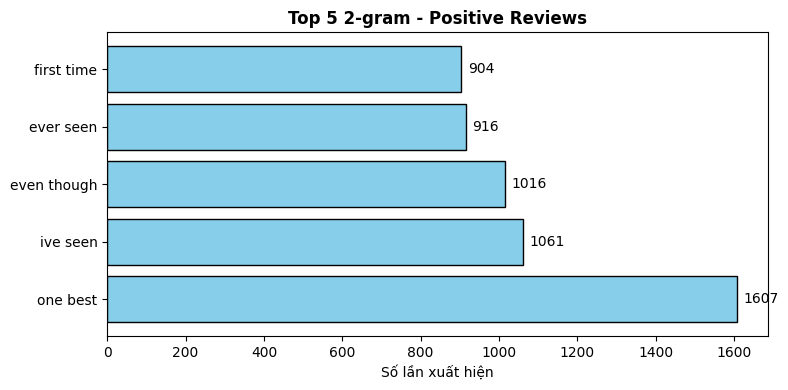

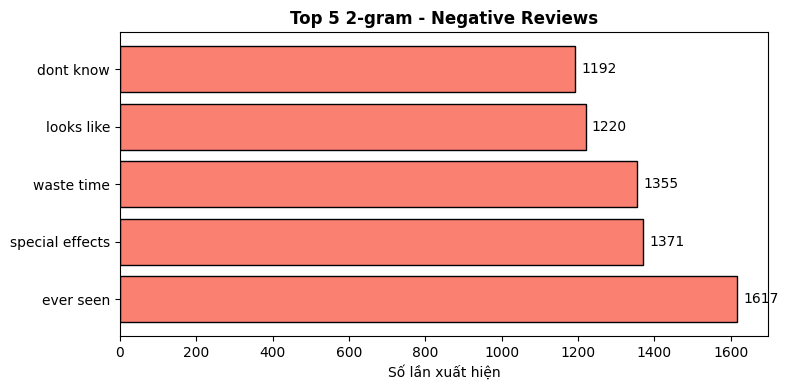

In [8]:
def plot_top_5_ngrams(corpus, ngram_range, title="", color='coral'):
    """
    Vẽ biểu đồ top 5 n-gram phổ biến
    """
    # Lấy n-gram với CountVectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=2000)
    X = vectorizer.fit_transform(corpus)

    # Lấy tên và số lần xuất hiện
    words = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1

    # Sắp xếp và lấy top 5
    sorted_indices = counts.argsort()[::-1][:5]
    top_words = [words[i] for i in sorted_indices]
    top_counts = counts[sorted_indices]

    # Vẽ biểu đồ ngang
    plt.figure(figsize=(8, 4))
    bars = plt.barh(range(5), top_counts, color=color, edgecolor='black')
    plt.yticks(range(5), top_words)
    plt.title(f'Top 5 {ngram_range[0]}-gram - {title}', fontsize=12, fontweight='bold')
    plt.xlabel('Số lần xuất hiện')

    # Hiển thị số trên mỗi cột
    for i, (bar, count) in enumerate(zip(bars, top_counts)):
        plt.text(count + max(top_counts)*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(count)}', va='center')

    plt.tight_layout()
    plt.show()
    return top_words, top_counts

# CHẠY Ở CELL CUỐI CÙNG HOẶC SAU KHI CÓ df
# Lấy review theo sentiment
pos_reviews = df[df['sentiment'] == 'positive']['cleanreview']
neg_reviews = df[df['sentiment'] == 'negative']['cleanreview']

# Bigram cho positive
top_pos_bi, counts_pos_bi = plot_top_5_ngrams(
    pos_reviews,
    ngram_range=(2,2),
    title="Positive Reviews",
    color='skyblue'
)

# Bigram cho negative
top_neg_bi, counts_neg_bi = plot_top_5_ngrams(
    neg_reviews,
    ngram_range=(2,2),
    title="Negative Reviews",
    color='salmon'
)

**CHẠY MÔ HÌNH**

In [9]:
# Hàm chung confushion matrix và đánh giá
def print_result(model_name, y_test, y_pred, y_score=None):
    print(f"\n===== {model_name.upper()} =====")

    print(classification_report(
        y_test,
        y_pred,
        target_names=["negative", "positive"]
    ))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    if y_score is not None:
        print(f"AUC: {roc_auc_score(y_test, y_score)}")

In [10]:
# Logicstic regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)

y_pred_lr = model_lr.predict(X_test_tfidf)
y_score_lr = model_lr.predict_proba(X_test_tfidf)[:, 1]

print_result(
    "Logistic Regression",
    y_test,
    y_pred_lr,
    y_score_lr
)


===== LOGISTIC REGRESSION =====
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion Matrix:
[[4453  547]
 [ 427 4573]]
Accuracy: 0.9026
AUC: 0.9659591599999999


In [11]:
# SVM
model_svm = LinearSVC()
model_svm.fit(X_train_tfidf, y_train)

y_pred_svm = model_svm.predict(X_test_tfidf)
y_score_svm = model_svm.decision_function(X_test_tfidf)

print_result(
    "SVM",
    y_test,
    y_pred_svm,
    y_score_svm
)



===== SVM =====
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      5000
    positive       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion Matrix:
[[4484  516]
 [ 463 4537]]
Accuracy: 0.9021
AUC: 0.9648162800000002


In [12]:
# Decision Tree
model_dt = DecisionTreeClassifier(
    max_depth=50,
    min_samples_split=10,
    random_state=42
)
model_dt.fit(X_train_tfidf, y_train)

y_pred_dt = model_dt.predict(X_test_tfidf)
y_score_dt = model_dt.predict_proba(X_test_tfidf)[:, 1]

print_result(
    "Decision Tree",
    y_test,
    y_pred_dt,
    y_score_dt
)



===== DECISION TREE =====
              precision    recall  f1-score   support

    negative       0.73      0.70      0.72      5000
    positive       0.72      0.75      0.73      5000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000

Confusion Matrix:
[[3522 1478]
 [1271 3729]]
Accuracy: 0.7251
AUC: 0.7235526999999999
